<a href="https://colab.research.google.com/github/saifeddineboukhdhir/Image-mining/blob/main/Lab_2_Deep_Learning_with_PyTorch_CIFAR10_object_classification_Saif_Eddine_BOUKHDHIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Deep Learning for Image Classification <h1>

---



<h5>$\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:$ Done by: Saif Eddine BOUKHDIR<h5> 

During this law work, we implement,train and test a Convolutional Neural Network to classify images of 10 different classes (dogs, cats, car, ...). This neural network is optimized by changing its archietcture and some of its hyperparameters. <br> 
The mean goal is to obtain the best accuaccuracyon the test set.  

We start by copying some functions given by the lab work organiser .

Here we import useful predepredefined functions and libralibrarie. 

In [2]:
%matplotlib inline
# Useful imports
from __future__ import print_function, division
import itertools
import time
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch as th
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Plotting functions and useful imports

In [3]:
# Python 2/3 compatibility
from __future__ import print_function, division

import itertools
import time


import numpy as np
import matplotlib.pyplot as plt

# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

# functions to show an image
def imshow(img):
    """
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    plt.imshow(np.transpose(npimg, (1, 2, 0)))



def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training and validation loss")
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    :param cm: (numpy matrix) confusion matrix
    :param classes: [str]
    :param normalize: (bool)
    :param title: (str)
    :param cmap: (matplotlib color map)
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 8))   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

For this lab work, we will use the CIFAR10 dataset. There are 10 classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

Seed the random generator to have reproducible results

In [4]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

if th.cuda.is_available():
  # Make CuDNN Determinist
  th.backends.cudnn.deterministic = True
  th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")

 Loading and normalizing CIFAR10 Dataset

In [5]:
n_training_samples = 40000 # Max: 50 000 - n_val_samples
n_val_samples = 10000


train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))
#test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))  # we can use it to test on a subset
# (In the last case, indexes do not need to account for training ones because the train=False parameter in datasets.CIFAR will select from the test set)

In [6]:
num_workers = 5
test_batch_size = 4

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=test_batch_size, sampler=train_sampler,
                                          num_workers=num_workers)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size,
                                         num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Failed download. Trying https -> http instead. Downloading http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified



Define a loss function and optimizer

In [7]:
def createLossAndOptimizer(net, learning_rate=0.001):
    # it combines softmax with negative log likelihood loss
    criterion = nn.CrossEntropyLoss()  
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    # training the model using AdamW
    #optimizer = optim.AdamW(net.parameters(), lr=learning_rate)
    # we train the model using Adam 
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    return criterion, optimizer

Data loader

In [8]:
def get_train_loader(batch_size):
    return torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler,
                                              num_workers=num_workers)

# Use larger batch size for validation to speed up computation
val_loader = torch.utils.data.DataLoader(train_set, batch_size=128, sampler=val_sampler,
                                          num_workers=num_workers)

Training loop : <br> 
Note here the following function saves only the weights at epoch n that gave the best performance on the valid set. So we may train for N epochs, we only consider the model "stopped" at epoch n. And this is important because the model might be accurate first then depending on the hyperparameters, it might fail to converge so the performance gets worse. 

In [15]:
def train(net, batch_size, n_epochs, learning_rate, get_model = False ):
    """
    Train a neural network and print statistics of the training
    
    :param net: (PyTorch Neural Network)
    :param batch_size: (int)
    :param n_epochs: (int)  Number of iterations on the training set
    :param learning_rate: (float) learning rate used by the optimizer
    :param get_model : get the trained model after training  
    """
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("n_epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    train_loader = get_train_loader(batch_size)
    n_minibatches = len(train_loader)

    criterion, optimizer = createLossAndOptimizer(net, learning_rate)
    # Init variables used for plotting the loss
    train_history = []
    val_history = []

    training_start_time = time.time()
    best_error = np.inf
    best_model_path = "best_model.pth"
    
    # Move model to gpu if possible
    net = net.to(device)

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        print_every = n_minibatches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, (inputs, labels) in enumerate(train_loader):

            # Move tensors to correct device
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            total_train_loss += loss.item()

            # print every 10th of epoch
            if (i + 1) % (print_every + 1) == 0:    
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                      epoch + 1, int(100 * (i + 1) / n_minibatches), running_loss / print_every,
                      time.time() - start_time))
                running_loss = 0.0
                start_time = time.time()

        train_history.append(total_train_loss / len(train_loader))

        total_val_loss = 0
        # Do a pass on the validation set
        # We don't need to compute gradient,
        # we save memory and computation using th.no_grad()
        with th.no_grad():
          for inputs, labels in val_loader:
              # Move tensors to correct device
              inputs, labels = inputs.to(device), labels.to(device)
              # Forward pass
              predictions = net(inputs)
              val_loss = criterion(predictions, labels)
              total_val_loss += val_loss.item()
            
        val_history.append(total_val_loss / len(val_loader))
        # Save model that performs best on validation set
        if total_val_loss < best_error:
            best_error = total_val_loss
            th.save(net.state_dict(), best_model_path)

        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))

    print("Training Finished, took {:.2f}s".format(time.time() - training_start_time))
    
    # Load best model
    net.load_state_dict(th.load(best_model_path))
    if get_model : 
      return train_history, val_history, net
    
    return train_history, val_history

Let us look at how the network performs on the whole test set.

In [10]:
def dataset_accuracy(net, data_loader, name=""):
    net = net.to(device)
    correct = 0
    total = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    accuracy = 100 * float(correct) / total
    print('Accuracy of the network on the {} {} images: {:.2f} %'.format(total, name, accuracy))

def train_set_accuracy(net):
    dataset_accuracy(net, train_loader, "train")

def val_set_accuracy(net):
    dataset_accuracy(net, val_loader, "validation")  
    
def test_set_accuracy(net):
    dataset_accuracy(net, test_loader, "test")

def compute_accuracy(net):
    train_set_accuracy(net)
    val_set_accuracy(net)
    test_set_accuracy(net)
    
print("Computing accuracy...")

Computing accuracy...


In [11]:
def accuracy_per_class(net):
    net = net.to(device)
    n_classes = 10
    # (real, predicted)
    confusion_matrix = np.zeros((n_classes, n_classes), dtype=np.int64)

    for images, labels in test_loader:
        images, labels = images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(test_batch_size):
            confusion_matrix[labels[i], predicted[i]] += 1
            label = labels[i]

    print("{:<10} {:^10}".format("Class", "Accuracy (%)"))
    for i in range(n_classes):
        class_total = confusion_matrix[i, :].sum()
        class_correct = confusion_matrix[i, i]
        percentage_correct = 100.0 * float(class_correct) / class_total
        
        print('{:<10} {:^10.2f}'.format(classes[i], percentage_correct))
    return confusion_matrix



In [12]:
def get_output_size(in_size, kernel_size, stride=1, padding=0):
    """
    Get the output size given all the parameters of the convolution
    :param in_size: (int) input size
    :param kernel_size: (int)
    :param stride: (int)
    :param paddind: (int)
    :return: (int)
    """
    return int((in_size - kernel_size + 2 * padding) / stride) + 1

<h2> I- Training the classifier <h2>

Now we start training our model in order to classify CIFAR-10 classes. <br>
Our first goal is to optimize the architectureof the network by adding more layers (convolution and/or fully connected layers) and/or changing the type of convolution and/or changing the parameters of some layers. 

We start with an architecture that is given by this lab work organizer. The model has one convolution layer, maxpooling layer and two fully-connected layers.  

In [ ]:
class SimpleConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(SimpleConvolutionalNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # on the shape (how we pass from a 3x32x32 input image to a 18x16x16 volume)
        self.fc1 = nn.Linear(18 * 16 * 16, 64) 
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        """
        # shape : 3x32x32 -> 18x32x32
        x = F.relu(self.conv1(x))
        # 18x32x32 -> 18x16x16
        x = self.pool(x)
        # 18x16x16 -> 4608
        x = x.view(-1, 18 * 16 * 16)
        # 4608 -> 64
        x = F.relu(self.fc1(x))
        # 64 -> 10
        x = self.fc2(x)
        return x

We train this model. First, we focus only on the training/validation losses and the total accuracy . This gives us a general idea about the performance of the model. It is obvious that we should not focus only on the whole accuracy because seeing how the model behaves with every class is crucial too (this can be done by plotting the confusion matrix).

We fix some hyperparameters in order to see the influence of the architecture on the total accuracy:  
* the batch size = 32
* Adam optimizer 
* total number of epochs = 10 
* learning rate  = 10e-3


In [ ]:
net = SimpleConvolutionalNetwork()
train_history, val_history = train(net, batch_size=32, n_epochs=10, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 10
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 1.96 took: 3.21s
Epoch 1, 20% 	 train_loss: 1.64 took: 2.70s
Epoch 1, 30% 	 train_loss: 1.51 took: 2.72s
Epoch 1, 40% 	 train_loss: 1.44 took: 2.71s
Epoch 1, 50% 	 train_loss: 1.40 took: 2.71s
Epoch 1, 60% 	 train_loss: 1.36 took: 2.92s
Epoch 1, 70% 	 train_loss: 1.35 took: 3.09s
Epoch 1, 80% 	 train_loss: 1.28 took: 2.99s
Epoch 1, 90% 	 train_loss: 1.29 took: 3.00s
Validation loss = 1.23
Epoch 2, 10% 	 train_loss: 1.19 took: 3.13s
Epoch 2, 20% 	 train_loss: 1.21 took: 2.95s
Epoch 2, 30% 	 train_loss: 1.21 took: 2.99s
Epoch 2, 40% 	 train_loss: 1.18 took: 2.96s
Epoch 2, 50% 	 train_loss: 1.14 took: 2.99s
Epoch 2, 60% 	 train_loss: 1.18 took: 3.01s
Epoch 2, 70% 	 train_loss: 1.14 took: 2.99s
Epoch 2, 80% 	 train_loss: 1.13 took: 2.93s
Epoch 2, 90% 	 train_loss: 1.17 took: 2.99s
Validation loss = 1.22
Epoch 3, 10% 	 train_loss: 1.04 took: 3.08s
Epoch 3, 20% 	 train_loss: 1.05 took: 2.9

Accuracy of the network on the 40000 train images: 74.66 %
Accuracy of the network on the 10000 validation images: 63.30 %
Accuracy of the network on the 10000 test images: 63.11 %


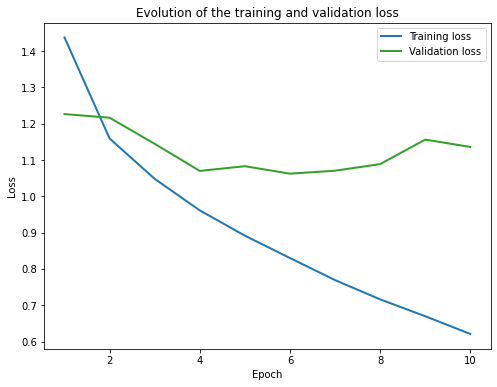

In [ ]:
compute_accuracy(net)
plot_losses(train_history, val_history)

Since the network is small,the training runtime is quite short. <br> 
By plotting the training and valid loss, we can see first that over the epochs, the loss functions descrease. But, the valid loss does not decrease the same way as the train loss. And unfortunately, after a certain number of epochs it starts to increase. <br> 
==> We have a problem of Overfitting. This issue will be our main ennemie while optimizing of our model performance, because our goal is to push the network to learn more and more and at some point it may lose its capacity of generelizing knowledge on a new test set. In that case, a trade-off should be made in order to guarantee an acceptable performance. <br> 
Our starting point accuracy on the test set is 63.11% . This value should inscrease if we add some more layers. 

In [ ]:
confusion_matrix = accuracy_per_class(net)

Class      Accuracy (%)
plane        66.00   
car          60.60   
bird         46.40   
cat          50.10   
deer         64.20   
dog          48.40   
frog         68.30   
horse        73.90   
ship         76.30   
truck        76.90   


If we have a look at the accuracy of the model by class we can see that there is a huge difference in performance between classes. The model has some difficulty classifying the features labeled "bird", "cat" and "dog".   

<h2> II- Model Optimization <h2>

<h3>1- Influence of adding more convolution layers:<h3> <br>
 

We add 2 more convolution layers to our previous model. We choose to increase the number of output channels of the second convolution layer in order to extract more information from image. This should help the network to distinguish more easily between classes.

In [ ]:
# Importance of adding more convolution layers 
class MyConvolutionalNetwork_V1(nn.Module):
    def __init__(self):
        super(MyConvolutionalNetwork_V1, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(18, 36, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(36, 18, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # on the shape (how we pass from a 3x32x32 input image to a 18x16x16 volume)
        self.fc1 = nn.Linear(18 * 16 * 16, 64) 
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        """
        # shape : 3x32x32 -> 18x32x32
        x = F.relu(self.conv1(x))
        # 18x32x32 -> 18x16x16
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # 18x16x16 -> 4608
        x = x.view(-1, 18 * 16 * 16)
        # 4608 -> 64
        x = F.relu(self.fc1(x))
        # 64 -> 10
        x = self.fc2(x)
        return x

In [ ]:
net_V1 = MyConvolutionalNetwork_V1()
train_history, val_history = train(net_V1, batch_size=32, n_epochs=10, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 10
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 1.96 took: 6.17s
Epoch 1, 20% 	 train_loss: 1.65 took: 6.06s
Epoch 1, 30% 	 train_loss: 1.56 took: 6.00s
Epoch 1, 40% 	 train_loss: 1.48 took: 5.94s
Epoch 1, 50% 	 train_loss: 1.43 took: 6.11s
Epoch 1, 60% 	 train_loss: 1.34 took: 6.39s
Epoch 1, 70% 	 train_loss: 1.33 took: 6.29s
Epoch 1, 80% 	 train_loss: 1.30 took: 6.20s
Epoch 1, 90% 	 train_loss: 1.26 took: 6.20s
Validation loss = 1.25
Epoch 2, 10% 	 train_loss: 1.18 took: 6.39s
Epoch 2, 20% 	 train_loss: 1.15 took: 6.20s
Epoch 2, 30% 	 train_loss: 1.15 took: 6.32s
Epoch 2, 40% 	 train_loss: 1.14 took: 6.17s
Epoch 2, 50% 	 train_loss: 1.09 took: 6.22s
Epoch 2, 60% 	 train_loss: 1.09 took: 6.14s
Epoch 2, 70% 	 train_loss: 1.08 took: 6.16s
Epoch 2, 80% 	 train_loss: 1.09 took: 6.19s
Epoch 2, 90% 	 train_loss: 1.10 took: 6.20s
Validation loss = 1.06
Epoch 3, 10% 	 train_loss: 0.95 took: 6.32s
Epoch 3, 20% 	 train_loss: 0.98 took: 6.2

Accuracy of the network on the 40000 train images: 82.48 %
Accuracy of the network on the 10000 validation images: 67.29 %
Accuracy of the network on the 10000 test images: 67.01 %


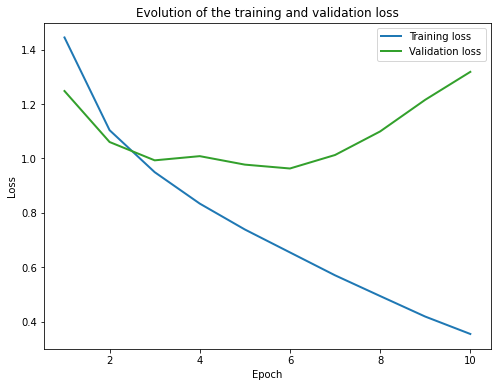

In [ ]:
compute_accuracy(net_V1)
plot_losses(train_history, val_history)

Adding new convolution layers helps descreasing the training loss. The test loss descreased at first then after a certain number of epochs it started to inscrease (overfitting). <br> 
==> A deeper network does not give always better results. A trade-off must be made <br>  
Although,we had a problem of overfitting more noticeable, the evaluation on the test set gave better accuracy (~ +4%) (we choose the best obtained weights over epochs). Now, our aim is to reduce the impact of overfitting and at the same time maintain an increasing accuracy value.  

In [ ]:
confusion_matrix = accuracy_per_class(net_V1)

Class      Accuracy (%)
plane        67.60   
car          77.00   
bird         62.90   
cat          45.00   
deer         63.00   
dog          56.00   
frog         75.30   
horse        68.20   
ship         81.10   
truck        74.00   


In general, the accuracy per class has got better. We should not stop at that point because we are not sure yet that thes values represent the true capacity of our classifier.  

<h3> 2 - Impact of batch normalization <h3>

Batch normalization is used to adjust and scale the feature maps.It increases the stability of the neural network. Furthermore, it reduces the impact fo overfitting beaucause it has some slight regularization effects. Also, it allows each layer of the network to better capture relevent features by itself and without relying too much on the other layers. 


We use the same network architecture as during the previous training, but we add only a batch normalization layer after every convolution layer (the most commun place to use batch normalization). Then, we train our model and we evaluate it.  

In [ ]:
# Importance of batch norm
class MyConvolutionalNetwork_V2(nn.Module):
    def __init__(self):
        super(MyConvolutionalNetwork_V2, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(18)
        self.conv2 = nn.Conv2d(18, 36, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(36)
        self.conv3 = nn.Conv2d(36, 18, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(18)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # on the shape (how we pass from a 3x32x32 input image to a 18x16x16 volume)
        self.fc1 = nn.Linear(18 * 16 * 16, 64) 
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        """
        # shape : 3x32x32 -> 18x32x32
        x = F.relu(self.bn1(self.conv1(x)))
        # 18x32x32 -> 18x16x16
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        # 18x16x16 -> 4608
        x = x.view(-1, 18 * 16 * 16)
        # 4608 -> 64
        x = F.relu(self.fc1(x))
        # 64 -> 10
        x = self.fc2(x)
        return x

In [ ]:
net_V2 = MyConvolutionalNetwork_V2()
train_history, val_history = train(net_V2, batch_size=32, n_epochs=10, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 10
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 1.81 took: 7.86s
Epoch 1, 20% 	 train_loss: 1.45 took: 7.74s
Epoch 1, 30% 	 train_loss: 1.39 took: 7.76s
Epoch 1, 40% 	 train_loss: 1.31 took: 7.82s
Epoch 1, 50% 	 train_loss: 1.27 took: 7.77s
Epoch 1, 60% 	 train_loss: 1.16 took: 8.01s
Epoch 1, 70% 	 train_loss: 1.18 took: 8.26s
Epoch 1, 80% 	 train_loss: 1.13 took: 8.12s
Epoch 1, 90% 	 train_loss: 1.08 took: 8.11s
Validation loss = 1.03
Epoch 2, 10% 	 train_loss: 1.04 took: 8.38s
Epoch 2, 20% 	 train_loss: 1.02 took: 8.14s
Epoch 2, 30% 	 train_loss: 0.98 took: 8.14s
Epoch 2, 40% 	 train_loss: 1.00 took: 8.16s
Epoch 2, 50% 	 train_loss: 0.99 took: 8.14s
Epoch 2, 60% 	 train_loss: 0.96 took: 8.17s
Epoch 2, 70% 	 train_loss: 0.98 took: 8.18s
Epoch 2, 80% 	 train_loss: 0.94 took: 8.19s
Epoch 2, 90% 	 train_loss: 0.96 took: 8.13s
Validation loss = 0.94
Epoch 3, 10% 	 train_loss: 0.87 took: 8.30s
Epoch 3, 20% 	 train_loss: 0.83 took: 8.1

Accuracy of the network on the 40000 train images: 78.30 %
Accuracy of the network on the 10000 validation images: 71.27 %
Accuracy of the network on the 10000 test images: 67.26 %


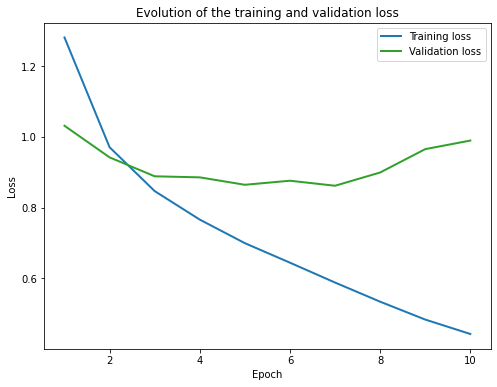

In [ ]:
compute_accuracy(net_V2)
plot_losses(train_history, val_history)

It is clear that the total runtime has increased because we added more layers and more parameters to learn (more precisely the "mean" parameter and the "standard diviation" parameter used for normalization). <br> 
Also, we can that gap between the training loss and the testing loss decreased. We reduced a bit the overfitting probelem. <br> 
But the total accuracy did not get improved. <br> 
==> We demonstrate the importance of Batch Normalization in terms of reducing the overfitting.  

In [ ]:
confusion_matrix = accuracy_per_class(net_V2)

Class      Accuracy (%)
plane        73.60   
car          86.80   
bird         48.80   
cat          44.00   
deer         65.90   
dog          56.90   
frog         65.20   
horse        80.00   
ship         81.60   
truck        69.80   


<h3> 3-Impact of the drop-out layers: <h3>

The dropout refers to deactivate some neurons chosen randomly in the network during training (while forward and backward propagating information through the network). <br> 
This method is used as a regularization technique to reduce the impact of overfitting by minimizing the interdependence between neurons. The model becomes more robust by looking only for relevent features. <br> 
The dropout layer is usually added between dense layers, but here we use too between convolutions layers because we have relatively small feature maps.<br> 
  

In [ ]:
# Importance of dropout
class MyConvolutionalNetwork_V3(nn.Module):
    def __init__(self):
        super(MyConvolutionalNetwork_V3, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(18)
        self.conv2 = nn.Conv2d(18, 36, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(36)
        self.conv3 = nn.Conv2d(36, 18, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(18)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        
        self.fc1 = nn.Linear(18 * 16 * 16, 64) 
        self.fc2 = nn.Linear(64, 10)
        # Dropout layers (10%)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        """
        # shape : 3x32x32 -> 18x32x32
        x = F.relu(self.bn1(self.conv1(x)))
        # 18x32x32 -> 18x16x16
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x= self.dropout(x)
        # 18x16x16 -> 4608
        x = x.view(-1, 18 * 16 * 16)
        # 4608 -> 64
        x = F.relu(self.fc1(x))
        x= self.dropout(x)
        # 64 -> 10
        x = self.fc2(x)
        return x

In [ ]:
net_V3 = MyConvolutionalNetwork_V3()
train_history, val_history = train(net_V3, batch_size=32, n_epochs=10, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 10
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 1.82 took: 8.23s
Epoch 1, 20% 	 train_loss: 1.52 took: 7.91s
Epoch 1, 30% 	 train_loss: 1.42 took: 7.91s
Epoch 1, 40% 	 train_loss: 1.37 took: 7.92s
Epoch 1, 50% 	 train_loss: 1.35 took: 8.02s
Epoch 1, 60% 	 train_loss: 1.27 took: 8.20s
Epoch 1, 70% 	 train_loss: 1.28 took: 8.44s
Epoch 1, 80% 	 train_loss: 1.26 took: 8.24s
Epoch 1, 90% 	 train_loss: 1.23 took: 8.20s
Validation loss = 1.15
Epoch 2, 10% 	 train_loss: 1.11 took: 8.44s
Epoch 2, 20% 	 train_loss: 1.16 took: 8.30s
Epoch 2, 30% 	 train_loss: 1.07 took: 8.31s
Epoch 2, 40% 	 train_loss: 1.10 took: 8.27s
Epoch 2, 50% 	 train_loss: 1.11 took: 8.35s
Epoch 2, 60% 	 train_loss: 1.09 took: 8.34s
Epoch 2, 70% 	 train_loss: 1.09 took: 8.38s
Epoch 2, 80% 	 train_loss: 1.07 took: 8.43s
Epoch 2, 90% 	 train_loss: 1.06 took: 8.54s
Validation loss = 1.02
Epoch 3, 10% 	 train_loss: 0.99 took: 8.59s
Epoch 3, 20% 	 train_loss: 1.00 took: 8.4

Accuracy of the network on the 40000 train images: 69.28 %
Accuracy of the network on the 10000 validation images: 67.30 %
Accuracy of the network on the 10000 test images: 62.89 %


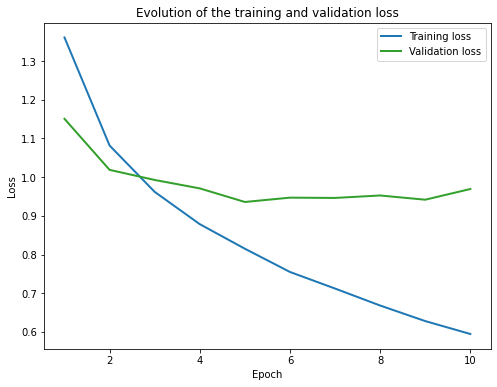

In [ ]:
compute_accuracy(net_V3)
plot_losses(train_history, val_history)

As prediced, the gap between the training loss and valid loss got minimized. But, the performance of the model decreased, this is due to the fact that it is important to choose the right place to apply dropout, because sometimes, we need  all neurons in th layer to dicide especially when working with a small network and a small input image as in our case. <br> 
We can vary the value of percentage of deactivated neurons and study its influence on the total accuracy value.  

<h3> 4- Combining all methods used above: <h3>

Now, we combine all the improvement that we have added so far on a new network architecture. Also, we add new dense layers and we inscrease the number of output channels in the comvoltion layers. <br> 
==> The model becomes deeper (more learnable parameters) : so it needs more time to learn (and also more data). <br> 
This the architecture that we choose:
*  4 convolution layers with batch normalization
*  2 maxpooling layers (to more concentate the data and reduce the complexity of the model)
*  5 dropout layers (10% of deactivated neurons)  
*  3 dense layers  <br> 
==> let's train our model   

In [ ]:
class MyConvolutionalNetwork_V4(nn.Module):
    def __init__(self):
        super(MyConvolutionalNetwork_V4, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.1)
        # on the shape (how we pass from a 3x32x32 input image to a 18x16x16 volume)
        self.fc1 = nn.Linear(8 * 8 * 64, 128 ) 
        self.bn_fc1 = nn.BatchNorm2d(128 )
        self.fc1_1 = nn.Linear(128, 64 ) 
        self.bn_fc1_1 = nn.BatchNorm2d(64 )
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        """
        # shape : 3x32x32 -> 18x32x32
        x = F.relu(self.bn1(self.conv1(x)))
        #x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x= self.dropout(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x= self.dropout(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x= self.dropout(x)
        x = x.view(-1, 8 * 8 * 64)

        x = F.relu(self.fc1(x))
        #x= self.bn_fc1(x)
        x= self.dropout(x)

        x = F.relu(self.fc1_1(x))
        #x= self.bn_fc1_1(x)
        x= self.dropout(x)

        # 128 -> 10
        x = self.fc2(x)
        return x

In [ ]:
net_V4 = MyConvolutionalNetwork_V4()
train_history, val_history = train(net_V4, batch_size=32, n_epochs=10, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 10
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 1.93 took: 22.32s
Epoch 1, 20% 	 train_loss: 1.58 took: 21.97s
Epoch 1, 30% 	 train_loss: 1.48 took: 21.96s
Epoch 1, 40% 	 train_loss: 1.39 took: 22.00s
Epoch 1, 50% 	 train_loss: 1.33 took: 21.94s
Epoch 1, 60% 	 train_loss: 1.27 took: 22.63s
Epoch 1, 70% 	 train_loss: 1.23 took: 23.21s
Epoch 1, 80% 	 train_loss: 1.21 took: 22.81s
Epoch 1, 90% 	 train_loss: 1.15 took: 22.78s
Validation loss = 1.11
Epoch 2, 10% 	 train_loss: 1.09 took: 23.07s
Epoch 2, 20% 	 train_loss: 1.04 took: 22.80s
Epoch 2, 30% 	 train_loss: 1.04 took: 22.86s
Epoch 2, 40% 	 train_loss: 1.03 took: 22.91s
Epoch 2, 50% 	 train_loss: 1.02 took: 22.70s
Epoch 2, 60% 	 train_loss: 0.98 took: 22.84s
Epoch 2, 70% 	 train_loss: 0.97 took: 22.97s
Epoch 2, 80% 	 train_loss: 0.96 took: 22.94s
Epoch 2, 90% 	 train_loss: 0.95 took: 23.01s
Validation loss = 0.93
Epoch 3, 10% 	 train_loss: 0.87 took: 23.49s
Epoch 3, 20% 	 train_l

Accuracy of the network on the 40000 train images: 79.68 %
Accuracy of the network on the 10000 validation images: 77.09 %
Accuracy of the network on the 10000 test images: 72.07 %


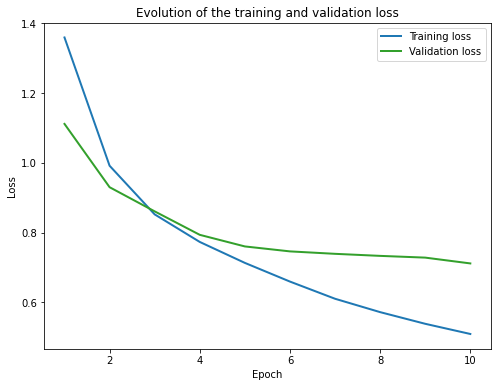

In [ ]:
compute_accuracy(net_V4)
plot_losses(train_history, val_history)

If we look that loss curves above, we can see that we have reduced dramatically the overfitting problem. The gap between the train loss and valid loss decreased. <br> 
After 10 epochs the valid loss did not inscrease, which means that we can still run our training process during more epochs without overfitting the model. <br> 
Now, if we have a look at the accuracy values,we can see the improvement of training and the test accuracy (~ +9% compared to the first simple model). However, the total training time has inscreased as well.  

<h3> 5- Impact of the learning rate: <h3> 


The learning rate is one of the most important hyperparameters that impact the learning process. It controls how the network weights are updated during the backpropagation. <br> 
Choosing the right value of the learning rate is very challenging: choosing a small value make the training process slower (and sometimes we could be stuck in a local minimum), and choosing a big value may cause an unstable learning process. <br> 
How to find the optimal value of the learning rate ?<br> 
we can choose a value that is independent of the training loss value and the epoch (value fixed between 0 and 1 from the beginning of the learning process) and also we can use an adaptive learning rate. It can depend on epochs (after n epochs we divide the initial learning rate by 10 for example), or it can depend on the training loss (if the training loss does not get improved over epochs we change the value of the learning rate).    

We have already used the value of 10e-3 (the training just above).<br> 
Now, we are going to multiply this value by 10 and by $10^{-1}$, and then observe its impact on the total accuracy. <br> 

First lr = $10^{-2}$ , and this value is not going to be changed over epochs.

In [ ]:
# hyperparameter optimization 
#learning rate 
#Fist value 10-e2 
net_V4_2 = MyConvolutionalNetwork_V4()
train_history, val_history = train(net_V4_2, batch_size=32, n_epochs=10, learning_rate=0.01)

===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 10
learning_rate= 0.01
Epoch 1, 10% 	 train_loss: 2.39 took: 22.39s
Epoch 1, 20% 	 train_loss: 2.02 took: 22.14s
Epoch 1, 30% 	 train_loss: 1.92 took: 22.11s
Epoch 1, 40% 	 train_loss: 1.88 took: 22.04s
Epoch 1, 50% 	 train_loss: 1.82 took: 22.04s
Epoch 1, 60% 	 train_loss: 1.78 took: 22.42s
Epoch 1, 70% 	 train_loss: 1.74 took: 23.34s
Epoch 1, 80% 	 train_loss: 1.70 took: 22.86s
Epoch 1, 90% 	 train_loss: 1.67 took: 22.85s
Validation loss = 1.55
Epoch 2, 10% 	 train_loss: 1.57 took: 23.14s
Epoch 2, 20% 	 train_loss: 1.58 took: 23.01s
Epoch 2, 30% 	 train_loss: 1.58 took: 23.37s
Epoch 2, 40% 	 train_loss: 1.52 took: 26.19s
Epoch 2, 50% 	 train_loss: 1.47 took: 23.10s
Epoch 2, 60% 	 train_loss: 1.46 took: 23.02s
Epoch 2, 70% 	 train_loss: 1.47 took: 22.94s
Epoch 2, 80% 	 train_loss: 1.44 took: 22.96s
Epoch 2, 90% 	 train_loss: 1.41 took: 22.94s
Validation loss = 1.37
Epoch 3, 10% 	 train_loss: 1.38 took: 23.22s
Epoch 3, 20% 	 train_lo

Accuracy of the network on the 40000 train images: 58.07 %
Accuracy of the network on the 10000 validation images: 60.36 %
Accuracy of the network on the 10000 test images: 56.03 %


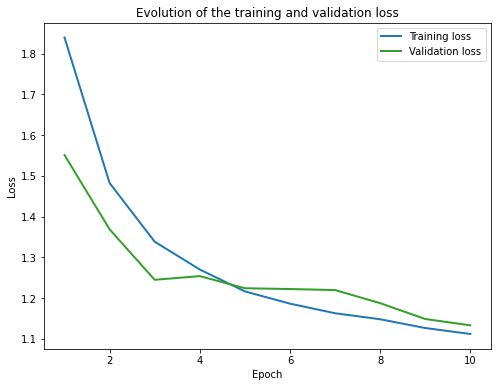

In [ ]:
compute_accuracy(net_V4_2)
plot_losses(train_history, val_history)


From the loss curves, we can see that the training loss and valid loss decrease almost simultaneously . That is great because the overfitting problem has not occurred yet. But, if we compare the loss values of this training process and the previous training process we can see that this value of learning learning did not help the model to update accurately and rapidly the weights. That's why we still have a high value of training/valid loss. As a result, we have a very bad total accuracy value (even worse that our first training).<br>  
==> Maybe if we give the model more time (inscrease the number of epochs), it will eventually have better performance. 

Now, we fix the value of the learning rate to $10^{-4}$. 

In [ ]:
net_V4_4 = MyConvolutionalNetwork_V4()
train_history, val_history = train(net_V4_4, batch_size=32, n_epochs=10, learning_rate=0.0001)

===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 10
learning_rate= 0.0001
Epoch 1, 10% 	 train_loss: 2.12 took: 22.40s
Epoch 1, 20% 	 train_loss: 1.80 took: 22.15s
Epoch 1, 30% 	 train_loss: 1.67 took: 22.28s
Epoch 1, 40% 	 train_loss: 1.60 took: 22.18s
Epoch 1, 50% 	 train_loss: 1.52 took: 22.19s
Epoch 1, 60% 	 train_loss: 1.48 took: 22.53s
Epoch 1, 70% 	 train_loss: 1.42 took: 22.55s
Epoch 1, 80% 	 train_loss: 1.40 took: 22.61s
Epoch 1, 90% 	 train_loss: 1.35 took: 22.69s
Validation loss = 1.28
Epoch 2, 10% 	 train_loss: 1.29 took: 22.95s
Epoch 2, 20% 	 train_loss: 1.22 took: 22.59s
Epoch 2, 30% 	 train_loss: 1.21 took: 22.56s
Epoch 2, 40% 	 train_loss: 1.18 took: 22.67s
Epoch 2, 50% 	 train_loss: 1.18 took: 22.68s
Epoch 2, 60% 	 train_loss: 1.13 took: 22.65s
Epoch 2, 70% 	 train_loss: 1.15 took: 22.66s
Epoch 2, 80% 	 train_loss: 1.11 took: 22.67s
Epoch 2, 90% 	 train_loss: 1.11 took: 22.88s
Validation loss = 1.07
Epoch 3, 10% 	 train_loss: 1.04 took: 23.12s
Epoch 3, 20% 	 train_

Accuracy of the network on the 40000 train images: 73.98 %
Accuracy of the network on the 10000 validation images: 73.63 %
Accuracy of the network on the 10000 test images: 69.62 %


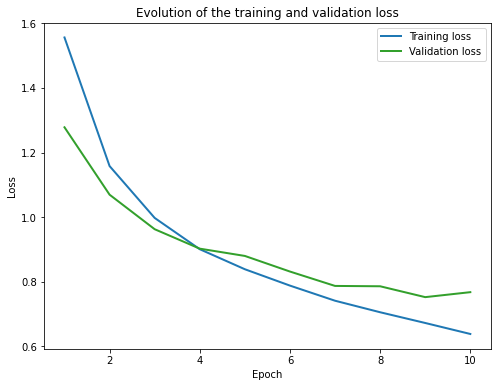

In [ ]:
compute_accuracy(net_V4_4)
plot_losses(train_history, val_history)

Based on the loss curves, we can see that this learning rate reduced the overfitting problem . But, the model got stuck in a local minimum that's why the value of loss at epoch 10 is higher than its value at epoch 10 while using lr = $10^{-3}$. As a consequence, we have a lower value of total accuracy. <br> 
==> Based on the previous three trainings, we can see the importance of the value of learning rate and how it impacts the total accuracy.
<br> we will use the value $10^{-2}$ for the following trainings. 

<h3> 6- Impact of Batch size: <h3>

When we changed the network architecture (inscreasing the total number of learnable paramaters) , the training time raised dramatically. That's why we should optimize the number of batch size. <br> 
The batch size defines the total number of used samples during one single forward/backward propagation. The higher its value, the more memory is needed to compute the operations.<br> 
It has been proven that using a small batch size, the convergence state is reached quicker than using the whole dataset/big batch size. That means that we need less epochs to reach a good performance. That's why we are going to test an even smaller batch size (16). 


In [ ]:
net_V4 = MyConvolutionalNetwork_V4()
train_history, val_history = train(net_V4, batch_size=16, n_epochs=10, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 16
n_epochs= 10
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 1.95 took: 23.71s
Epoch 1, 20% 	 train_loss: 1.63 took: 23.38s
Epoch 1, 30% 	 train_loss: 1.54 took: 23.94s
Epoch 1, 40% 	 train_loss: 1.45 took: 25.30s
Epoch 1, 50% 	 train_loss: 1.39 took: 25.02s
Epoch 1, 60% 	 train_loss: 1.34 took: 24.90s
Epoch 1, 70% 	 train_loss: 1.27 took: 24.92s
Epoch 1, 80% 	 train_loss: 1.23 took: 24.86s
Epoch 1, 90% 	 train_loss: 1.21 took: 24.98s
Validation loss = 1.14
Epoch 2, 10% 	 train_loss: 1.13 took: 25.08s
Epoch 2, 20% 	 train_loss: 1.10 took: 25.02s
Epoch 2, 30% 	 train_loss: 1.09 took: 25.12s
Epoch 2, 40% 	 train_loss: 1.07 took: 25.06s
Epoch 2, 50% 	 train_loss: 1.06 took: 25.01s
Epoch 2, 60% 	 train_loss: 1.04 took: 25.30s
Epoch 2, 70% 	 train_loss: 1.00 took: 25.15s
Epoch 2, 80% 	 train_loss: 1.03 took: 25.12s
Epoch 2, 90% 	 train_loss: 0.93 took: 24.97s
Validation loss = 0.94
Epoch 3, 10% 	 train_loss: 0.92 took: 25.25s
Epoch 3, 20% 	 train_l

Accuracy of the network on the 40000 train images: 81.63 %
Accuracy of the network on the 10000 validation images: 76.86 %
Accuracy of the network on the 10000 test images: 73.05 %


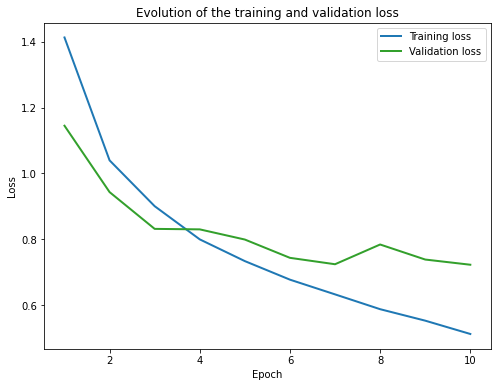

In [ ]:
compute_accuracy(net_V4)
plot_losses(train_history, val_history)

The fact that we decreased the batch size, the convergence of the model becomes faster and we got better accuracy (~ +10%  compared to our first model on the test set). <br> 
Also, we can see that the overfitting problem did not occur during the first 10 epochs, so we can still train our model during more epochs. 

<h2>Conclusions about what we have we seen so far <h2> 

* Convolutions layers are very important to extract features from an image
* Overfitting is a serious problem and it impacts heavily on the final accuarcy. 
* Batch normalization and dropout layers minimize the influence of overfitting. 
* The learning rate is so important to have a stable convergence. 
* The batch size impact dramatically the accuracy of the model.  

<h2> III- More sophisticated modifications <h2> 


<h3>1- Changing the optimizer : <h3> 


From the beginning of this lab work, we have chosen to work with Adam as an optimizer. In fact, it is an extension to SGD that is more powerful while updating weights based on the training data. <br> 
There are many benefits from using Adam insead of the classical SGD: for instance, it is computationally efficient and it deals well with noisy gradients. <br> 
Also, it has been shown that Adam is better than AdaGrad and RMSProp. That's why we are going to keep Adam as an optimizer but we are going to choose another variety of Adam : AdamW . <br>
AdamW : prensents a modification of weight decay (L2 regularization) by "decoupling the weight decay from the optimization steps". <br> 

Let's train our model using this optimizer: 


We add a line in the funtion "createLossAndOptimizer" defined above in order to choose AdamW as optimizer.


In [ ]:
net_V4 = MyConvolutionalNetwork_V4()
train_history, val_history = train(net_V4, batch_size=16, n_epochs=10, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 16
n_epochs= 10
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 2.00 took: 23.79s
Epoch 1, 20% 	 train_loss: 1.64 took: 23.58s
Epoch 1, 30% 	 train_loss: 1.52 took: 24.22s
Epoch 1, 40% 	 train_loss: 1.43 took: 25.64s
Epoch 1, 50% 	 train_loss: 1.37 took: 25.48s
Epoch 1, 60% 	 train_loss: 1.34 took: 25.57s
Epoch 1, 70% 	 train_loss: 1.30 took: 25.46s
Epoch 1, 80% 	 train_loss: 1.23 took: 25.35s
Epoch 1, 90% 	 train_loss: 1.19 took: 25.28s
Validation loss = 1.13
Epoch 2, 10% 	 train_loss: 1.12 took: 25.78s
Epoch 2, 20% 	 train_loss: 1.08 took: 25.65s
Epoch 2, 30% 	 train_loss: 1.09 took: 25.46s
Epoch 2, 40% 	 train_loss: 1.07 took: 25.42s
Epoch 2, 50% 	 train_loss: 1.07 took: 25.45s
Epoch 2, 60% 	 train_loss: 1.04 took: 25.42s
Epoch 2, 70% 	 train_loss: 1.00 took: 25.67s
Epoch 2, 80% 	 train_loss: 1.02 took: 25.59s
Epoch 2, 90% 	 train_loss: 0.98 took: 25.47s
Validation loss = 0.96
Epoch 3, 10% 	 train_loss: 0.93 took: 25.64s
Epoch 3, 20% 	 train_l

Accuracy of the network on the 40000 train images: 80.34 %
Accuracy of the network on the 10000 validation images: 75.52 %
Accuracy of the network on the 10000 test images: 72.11 %


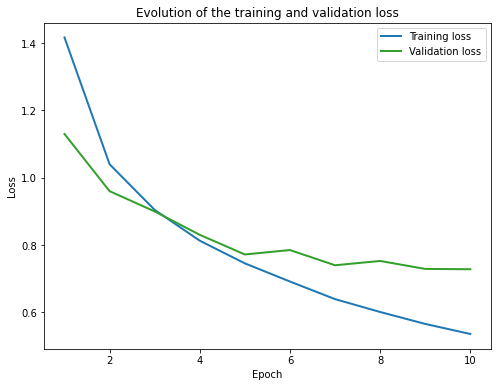

In [ ]:
compute_accuracy(net_V4)
plot_losses(train_history, val_history)

If we look at the obtained graph with the same network during the previous training, we can say that the loss funtions decrease faster with AdamW, but unfortunately we do not have an improvement of the total accuracy. That's why we will just keep Adam as an optimizer. 

<h3>2- Checking if the training set is balanced between all classes : <h3> 

A balanced training set is a set that presents equally (or almost) the same number of training samples from every class. 
An unbalanced training sets impact on the accuracy of the underpresented class. <br> 
Sometimes we may have a very good total accuracy but a poor accuracy per class (fraud problem for instance), that's why checking the accuracy per class is important. <br> 
It is crucial to find solutions in order to give the model a balanced data set (during the training as well as during the testing process). 

In [ ]:
# computing the percentage of samples for every class in the whole training set 
classes=[i for i in range(10)]
labels_counter = {}
for label in classes: 
  labels_counter[label] = 0
counter= 0  
for i, (inputs, labels) in enumerate(train_loader):
            # Move tensors to correct device
            inputs, labels = inputs.to(device), labels.to(device)
            for l in labels.numpy():
              counter +=1
              labels_counter[l] += 1 

for label in classes: 
  labels_counter[label] = round(labels_counter[label]*100/counter,2)

print("labels from training set ", labels_counter)  
            

labels from training set  {0: 9.96, 1: 9.96, 2: 10.12, 3: 9.96, 4: 10.01, 5: 9.94, 6: 10.05, 7: 10.06, 8: 9.99, 9: 9.95}


We can see from the dictionary {class : percentage of labeled samples in dataset } just above that our training set is balanced (every class presents almost 10% of the whole training data set). 

In [ ]:
classes=[i for i in range(10)]
labels_counter = {}
for label in classes: 
  labels_counter[label] = 0
counter= 0  
for i, (inputs, labels) in enumerate(test_loader):
            # Move tensors to correct device
            inputs, labels = inputs.to(device), labels.to(device)
            for l in labels.numpy():
              counter +=1
              labels_counter[l] += 1 

for label in classes: 
  labels_counter[label] = round(labels_counter[label]*100/counter,2)

print("labels from testing set ", labels_counter)

labels from testing set  {0: 10.0, 1: 10.0, 2: 10.0, 3: 10.0, 4: 10.0, 5: 10.0, 6: 10.0, 7: 10.0, 8: 10.0, 9: 10.0}


We have the same conclusion as with the train set. 

<h3> 3- Data augmenation :  Flipping images <h3>

In order to enlarge the training set by adding slighly different images, we can use apply the method "flip" (right to left or left to right).  This classic data augmenation technique helps the model to reduce the overfitting problem and to become more robust.  What we can do is at each epoch we flip a certain number of images with a probability p (0.5 by default). <br> 
To do so we can use the fonction : 

In [ ]:
x= torch.flip(x, [0, 1])

<h2> IV- Final Training and evaluation : finding the best total number of epochs:

Now, after trying to optimize the network architecture and its hyperparameters, we combine all our conclusions above and we train our model for 30 epochs. Finally we will figure out the best epoch to stop training in order to avoid overfitting.  

In [13]:
class MyConvolutionalNetwork_final_version(nn.Module):
    def __init__(self):
        super(MyConvolutionalNetwork_final_version, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.1)
        # on the shape (how we pass from a 3x32x32 input image to a 18x16x16 volume)
        self.fc1 = nn.Linear(8 * 8 * 64, 128 ) 
        self.bn_fc1 = nn.BatchNorm2d(128 )
        self.fc1_1 = nn.Linear(128, 64 ) 
        self.bn_fc1_1 = nn.BatchNorm2d(64 )
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        """
        # shape : 3x32x32 -> 18x32x32
        x = F.relu(self.bn1(self.conv1(x)))
        #x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x= self.dropout(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x= self.dropout(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x= self.dropout(x)
        x = x.view(-1, 8 * 8 * 64)

        x = F.relu(self.fc1(x))
        #x= self.bn_fc1(x)
        x= self.dropout(x)

        x = F.relu(self.fc1_1(x))
        #x= self.bn_fc1_1(x)
        x= self.dropout(x)

        # 128 -> 10
        x = self.fc2(x)
        return x

In [ ]:
final_net = MyConvolutionalNetwork_final_version()
train_history, val_history = train(final_net, batch_size=16, n_epochs=30, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 16
n_epochs= 30
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 1.94 took: 24.74s
Epoch 1, 20% 	 train_loss: 1.63 took: 24.69s
Epoch 1, 30% 	 train_loss: 1.52 took: 24.85s
Epoch 1, 40% 	 train_loss: 1.41 took: 26.05s
Epoch 1, 50% 	 train_loss: 1.36 took: 25.77s
Epoch 1, 60% 	 train_loss: 1.28 took: 25.67s
Epoch 1, 70% 	 train_loss: 1.25 took: 25.67s
Epoch 1, 80% 	 train_loss: 1.23 took: 25.90s
Epoch 1, 90% 	 train_loss: 1.16 took: 26.61s
Validation loss = 1.08
Epoch 2, 10% 	 train_loss: 1.06 took: 26.11s
Epoch 2, 20% 	 train_loss: 1.10 took: 26.03s
Epoch 2, 30% 	 train_loss: 1.02 took: 29.86s
Epoch 2, 40% 	 train_loss: 1.05 took: 26.08s
Epoch 2, 50% 	 train_loss: 1.01 took: 26.13s
Epoch 2, 60% 	 train_loss: 1.02 took: 26.03s
Epoch 2, 70% 	 train_loss: 0.96 took: 26.10s
Epoch 2, 80% 	 train_loss: 0.98 took: 26.03s
Epoch 2, 90% 	 train_loss: 0.94 took: 26.04s
Validation loss = 0.92
Epoch 3, 10% 	 train_loss: 0.87 took: 26.21s
Epoch 3, 20% 	 train_l

Accuracy of the network on the 40000 train images: 79.30 %
Accuracy of the network on the 10000 validation images: 75.71 %
Accuracy of the network on the 10000 test images: 72.28 %


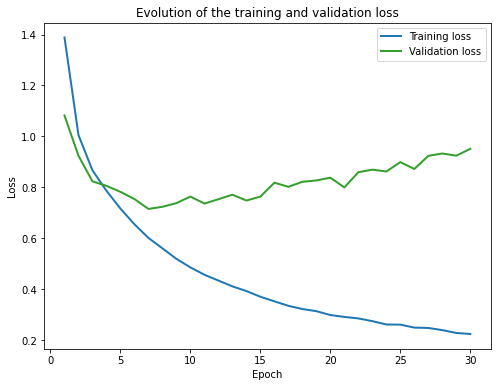

In [ ]:
compute_accuracy(final_net)
plot_losses(train_history, val_history)

After running the training process for many epochs (30),the model ended up by overfitting. (As it is shown in the figure above). <br> 
The training loss continues to descrease but the valid loss is increasing. Since the training process returns the weights that give the best accuracy on the valid set,we can say that best epoch is between 10 and 12.<br> 
We will retrain the model but now we will just run the training during 6 epochs using lr = $10^{-3}$ so that our model explores the best regions in order to minimize the loss then we will continue to train it during 6 other epochs with lr = $10^{-4}$. <br> 
We modify a bit the function "train" .

In [17]:
final_net = MyConvolutionalNetwork_final_version()
train_history, val_history, final_net = train(final_net, batch_size=16, n_epochs=  6 , learning_rate=0.001, get_model= True )
train_history, val_history = train(final_net, batch_size=16, n_epochs=6, learning_rate=0.0001)

===== HYPERPARAMETERS =====
batch_size= 16
n_epochs= 6
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 1.98 took: 25.08s
Epoch 1, 20% 	 train_loss: 1.71 took: 24.94s
Epoch 1, 30% 	 train_loss: 1.51 took: 25.57s
Epoch 1, 40% 	 train_loss: 1.49 took: 27.65s
Epoch 1, 50% 	 train_loss: 1.40 took: 27.01s
Epoch 1, 60% 	 train_loss: 1.37 took: 26.64s
Epoch 1, 70% 	 train_loss: 1.35 took: 26.68s
Epoch 1, 80% 	 train_loss: 1.30 took: 26.68s
Epoch 1, 90% 	 train_loss: 1.25 took: 26.79s
Validation loss = 1.16
Epoch 2, 10% 	 train_loss: 1.13 took: 29.19s
Epoch 2, 20% 	 train_loss: 1.14 took: 26.62s
Epoch 2, 30% 	 train_loss: 1.08 took: 26.53s
Epoch 2, 40% 	 train_loss: 1.05 took: 26.45s
Epoch 2, 50% 	 train_loss: 1.12 took: 27.55s
Epoch 2, 60% 	 train_loss: 1.03 took: 26.72s
Epoch 2, 70% 	 train_loss: 1.04 took: 26.37s
Epoch 2, 80% 	 train_loss: 1.06 took: 26.40s
Epoch 2, 90% 	 train_loss: 1.01 took: 26.33s
Validation loss = 0.98
Epoch 3, 10% 	 train_loss: 0.91 took: 27.29s
Epoch 3, 20% 	 train_lo

Accuracy of the network on the 40000 train images: 80.25 %
Accuracy of the network on the 10000 validation images: 77.21 %
Accuracy of the network on the 10000 test images: 73.48 %


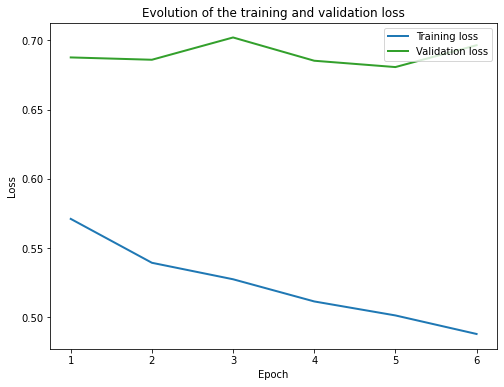

In [18]:
compute_accuracy(final_net)
plot_losses(train_history, val_history)

Here we present only the loss functions (when training with lr= $10^{-4}$) , we can see that over the epochs the valid loss does not inscreases : we can say that we stopped the overfiiting from happening. <br> 
The final total validation accuracy is 73.48 % (~ +10% )


Class      Accuracy (%)
plane        75.80   
car          85.30   
bird         57.90   
cat          57.30   
deer         70.30   
dog          62.40   
frog         78.30   
horse        79.00   
ship         83.50   
truck        85.20   


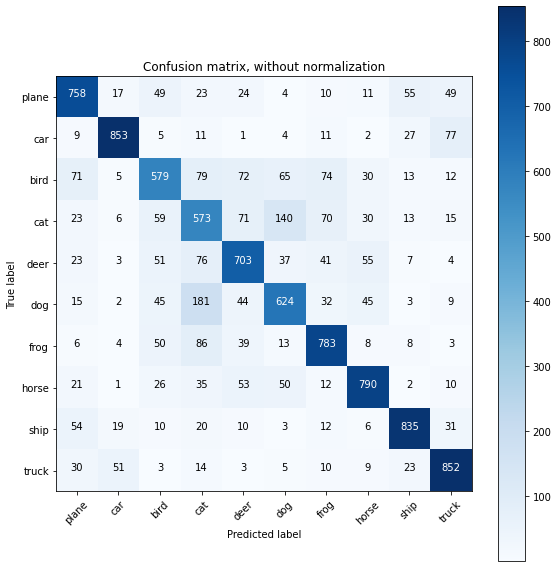

In [19]:
confusion_matrix = accuracy_per_class(final_net)
plot_confusion_matrix(confusion_matrix, classes,
                      title='Confusion matrix, without normalization')

In general the accuracy per class has inscreased, but the model is still confused between the class "Cat" and "Dog" . This is because semantically these two classes share some commun features. Since, the input image is a bit small, there are some caracteristic features for every class that can not be detected .   

<h2> V- Conclusion <h2> 

During this lab work, we train a CNN model on CIFAR10 database in order to classify 10 labels.  We started with a value of accuracy on the test set = 63.11 % (first simple cnn) and then we tried to optimize the network architecture and some hyperparmeters and we checked the balance of our training set, we managed to inscrease the performance of our classifier (test accuracy = 73.48 % ). <br> 

==> Test accuracy improvemnt: + 10 %  <br> 
Next steps: 
* Test more complex network architectures : 
https://paperswithcode.com/sota/image-classification-on-cifar-10  
* Focus on classes that have the worse accuracy per class.
* Apply  meta learning to optimize many hyperparametrs at the same time.
* Cross validation to have an accurate valisation process.
* Modify the loss function and/or add a regularization penalty to the loss. 
* More data augmenation techniques (Random Crop for example)   
* Replace the Relu activation function by Leaky ReLU

<h2> References: <h2>


* Ioffe, Sergey; Szegedy, Christian (2015). "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift".
* Effect of batch size on training dynamics: https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e
* LOSHCHILOV, Ilya et HUTTER, Frank. Decoupled weight decay regularization. arXiv preprint arXiv:1711.05101, 2017.
* KINGMA, Diederik P. et BA, Jimmy. Adam: A method for stochastic optimization. arXiv preprint arXiv:1412.6980, 2014.
* Adam optimization algorithm for deep learning: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/